# Byte-Pair Encoding tokenization

---
This notebook is a modified version of the Hugging Face tutorial course here (provided under an Apache License 2.0):
- Course: https://huggingface.co/learn/nlp-course/en/chapter6/5
- Notebook: https://colab.research.google.com/github/huggingface/notebooks/blob/master/course/en/chapter6/section5.ipynb
---

Byte-Pair Encoding (BPE) was initially developed as an algorithm to compress texts, and then used by OpenAI for tokenization when pretraining the GPT model. It’s used by a lot of Transformer models, including GPT, GPT-2, RoBERTa, BART, and DeBERTa.

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

## Training algorithm
BPE training starts by computing the unique set of words used in the corpus (after the normalization
and pre-tokenization steps are completed), then building the vocabulary by taking all the symbols 
used to write those words. As a very simple example, let’s say our corpus uses these five words:

```python
"hug", "pug", "pun", "bun", "hugs"
```

The base vocabulary will then be `["b", "g", "h", "n", "p", "s", "u"]`. For real-world cases, that base 
vocabulary will contain all the ASCII characters, at the very least, and probably some Unicode characters
as well. If an example you are tokenizing uses a character that is not in the training corpus, that 
character will be converted to the unknown token. That’s one reason why lots of NLP models are very 
bad at analyzing content with emojis, for instance.

After getting this base vocabulary, we add new tokens until the desired vocabulary size is reached by 
learning merges, which are rules to merge two elements of the existing vocabulary together into a new 
one. So, at the beginning these merges will create tokens with two characters, and then, as training 
progresses, longer subwords.

At any step during the tokenizer training, the BPE algorithm will search for the most frequent pair of
existing tokens (by “pair,” here we mean two consecutive tokens in a word). That most frequent pair is
the one that will be merged, and we rinse and repeat for the next step.

Going back to our previous example, let’s assume the words had the following frequencies:

```python
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)
```

meaning `"hug"` was present 10 times in the corpus, `"pug"` 5 times, "pun" 12 times, `"bun"` 4 times, and 
`"hugs"` 5 times. We start the training by splitting each word into characters (the ones that form our 
initial vocabulary) so we can see each word as a list of tokens:

```python
("h" "u" "g", 10), ("p" "u" "g", 5), ("p" "u" "n", 12), ("b" "u" "n", 4), ("h" "u" "g" "s", 5)
```

Then we look at pairs. The pair `("h", "u")` is present in the words `"hug"` and `"hugs"`, so 15 times total 
in the corpus. It’s not the most frequent pair, though: that honor belongs to `("u", "g")`, which is
present in `"hug", "pug", and "hugs"`, for a grand total of 20 times in the vocabulary.

Thus, the first merge rule learned by the tokenizer is `("u", "g") -> "ug"`, which means that `"ug"` will be
added to the vocabulary, and the pair should be merged in all the words of the corpus. At the end of this
stage, the vocabulary and corpus look like this:


```python
Vocabulary: ["b", "g", "h", "n", "p", "s", "u", "ug"]
Corpus: ("h" "ug", 10), ("p" "ug", 5), ("p" "u" "n", 12), ("b" "u" "n", 4), ("h" "ug" "s", 5)
```

Now we have some pairs that result in a token longer than two characters: the pair `("h", "ug")`, 
for instance (present 15 times in the corpus). The most frequent pair at this stage is `("u", "n")`, 
however, present 16 times in the corpus, so the second merge rule learned is `("u", "n") -> "un"`. 
Adding that to the vocabulary and merging all existing occurrences leads us to:

```python
Vocabulary: ["b", "g", "h", "n", "p", "s", "u", "ug", "un"]
Corpus: ("h" "ug", 10), ("p" "ug", 5), ("p" "un", 12), ("b" "un", 4), ("h" "ug" "s", 5)
```

Now the most frequent pair is `("h", "ug")`, so we learn the merge rule `("h", "ug") -> "hug"`, 
which gives us our first three-letter token. After the merge, the corpus looks like this:

```python
Vocabulary: ["b", "g", "h", "n", "p", "s", "u", "ug", "un", "hug"]
Corpus: ("hug", 10), ("p" "ug", 5), ("p" "un", 12), ("b" "un", 4), ("hug" "s", 5)
```

And we continue like this until we reach the desired vocabulary size.

<div style="background-color: #ccffcc; padding: 10px; border-radius: 5px;">
✏️ <b>Exercise</b>: Now your turn! What do you think the next merge rule will be?
</div>

## Tokenization algorithm

Tokenization follows the training process closely, in the sense that new inputs are tokenized by applying the following steps:

Normalization
Pre-tokenization
Splitting the words into individual characters
Applying the merge rules learned in order on those splits
Let’s take the example we used during training, with the three merge rules learned:

```python
("u", "g") -> "ug"
("u", "n") -> "un"
("h", "ug") -> "hug"
```

The word "bug" will be tokenized as `["b", "ug"]`. "mug", however, will be tokenized as `["[UNK]", "ug"]` since the letter `"m"` was not in the base vocabulary. Likewise, the word `"thug"` will be tokenized as `["[UNK]", "hug"]`: the letter `"t"` is not in the base vocabulary, and applying the merge rules results first in `"u"` and `"g"` being merged and then `"h"` and `"ug"` being merged.


<div style="background-color: #ccffcc; padding: 10px; border-radius: 5px;">
✏️ <b>Exercise</b>: Now your turn! How do you think the word "unhug" will be tokenized?
</div>

# Implementing BPE

Now let’s take a look at an implementation of the BPE algorithm. This won’t be an optimized 
version you can actually use on a big corpus; we just want to show you the code so you can 
understand the algorithm a little bit better.

### First we need a corpus, so let’s create a simple one with a few sentences:

In [ ]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

### Next, we need to pre-tokenize that corpus into words. 

Since we are replicating a BPE tokenizer (like GPT-2), we will use the gpt2 tokenizer for the pre-tokenization:

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

### Then we compute the frequencies of each word in the corpus as we do the pre-tokenization:

In [ ]:
from collections import defaultdict

word_freqs = defaultdict(int)

for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

print(word_freqs)

defaultdict(int, {'This': 3, 'Ġis': 2, 'Ġthe': 1, 'ĠHugging': 1, 'ĠFace': 1, 'ĠCourse': 1, '.': 4, 'Ġchapter': 1,
    'Ġabout': 1, 'Ġtokenization': 1, 'Ġsection': 1, 'Ġshows': 1, 'Ġseveral': 1, 'Ġtokenizer': 1, 'Ġalgorithms': 1,
    'Hopefully': 1, ',': 1, 'Ġyou': 1, 'Ġwill': 1, 'Ġbe': 1, 'Ġable': 1, 'Ġto': 1, 'Ġunderstand': 1, 'Ġhow': 1,
    'Ġthey': 1, 'Ġare': 1, 'Ġtrained': 1, 'Ġand': 1, 'Ġgenerate': 1, 'Ġtokens': 1})

### The next step is to compute the base vocabulary, formed by all the characters used in the corpus:

In [ ]:
alphabet = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()

print(alphabet)

[ ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's',
  't', 'u', 'v', 'w', 'y', 'z', 'Ġ']

#### We also add the special tokens used by the model at the beginning of that vocabulary. In the case of GPT-2, the only special token is `"<|endoftext|>"`:

In [ ]:
vocab = ["<|endoftext|>"] + alphabet.copy()

### We now need to split each word into individual characters, to be able to start training:

In [ ]:
splits = {word: [c for c in word] for word in word_freqs.keys()}

### Now that we are ready for training, let’s write a function that computes the frequency of each pair. We’ll need to use this at each step of the training:

In [ ]:
def compute_pair_freqs(splits):
    # Default dicts start at 0 for an integer
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        # Get the split of characters for the current word
        split = splits[word]
       
        # Case where there are no pairs
        if len(split) == 1:
            continue
            
        # Loop over each character pair and count their occurences
        for i in range(len(split) - 1):
            # Construct a pair tuple to have a unique hash
            pair = (split[i], split[i + 1])
            # Add the number of times this pair occurs in the entire corpus
            pair_freqs[pair] += freq
    return pair_freqs

#### Let’s have a look at a part of this dictionary after the initial splits:

In [ ]:
pair_freqs = compute_pair_freqs(splits)

# Print out some pairs
for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break

('T', 'h'): 3
('h', 'i'): 3
('i', 's'): 5
('Ġ', 'i'): 2
('Ġ', 't'): 7
('t', 'h'): 3

### Now, finding the most frequent pair only takes a quick loop:

In [ ]:
best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)

('Ġ', 't') 7

### So the first merge to learn is `('Ġ', 't') -> 'Ġt'`, and we add `'Ġt'` to the vocabulary:

In [ ]:
merges = {("Ġ", "t"): "Ġt"}
vocab.append("Ġt")

### To continue, we need to apply that merge in our splits dictionary. Let’s write another function for this:

In [ ]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        # Get the current split
        split = splits[word]
        
        # Case where there are no pairs
        if len(split) == 1:
            continue

        # Loop over the character pairs of the word
        i = 0
        while i < len(split) - 1:
            # Check if the current pair is equal to the input pair (a, b)
            if split[i] == a and split[i + 1] == b:
                # If it is, then reassign the split to be the original
                # list of characters with the (a, b) character pair 
                # concatenated as a single character.
                # Example:
                #  Inputs: a, b = "a", "t" 
                #  Before: split = ["c", "a", "t"]
                #  After: split = ["c"] + ["at"] + [] = ["c", "at"] 
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                # Advance the index, notice that we don't need to advance
                # the index in the previous case because the size of split
                # list gets shrunk by 1.
                i += 1

        # Finally, update the split for the next iteration of BPE training
        splits[word] = split
    return splits

#### And we can have a look at the result of the first merge:

In [ ]:
splits = merge_pair("Ġ", "t", splits)
print(splits["Ġtrained"])
# We see the first item has been merged

['Ġt', 'r', 'a', 'i', 'n', 'e', 'd']

### Now we have everything we need to loop until we have learned all the merges we want. Let’s aim for a vocab size of 50:

In [ ]:
vocab_size = 50

while len(vocab) < vocab_size:
    # Compute the pair frequencies of the new splits
    pair_freqs = compute_pair_freqs(splits)

    # Get the pair that occured the most 
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq

    # Merge each of the splits by concatenating all occurences of the best pair
    splits = merge_pair(*best_pair, splits)
    # Collect the merges to use during tokenization
    merges[best_pair] = best_pair[0] + best_pair[1]
    # Append the current best pair to the tokenizer vocabulary
    vocab.append(best_pair[0] + best_pair[1])

#### As a result, we’ve learned 19 merge rules (the initial vocabulary had a size of 31 — 30 characters in the alphabet, plus the special token):

In [ ]:
print(merges)

{('Ġ', 't'): 'Ġt', ('i', 's'): 'is', ('e', 'r'): 'er', ('Ġ', 'a'): 'Ġa', ('Ġt', 'o'): 'Ġto', ('e', 'n'): 'en',
 ('T', 'h'): 'Th', ('Th', 'is'): 'This', ('o', 'u'): 'ou', ('s', 'e'): 'se', ('Ġto', 'k'): 'Ġtok',
 ('Ġtok', 'en'): 'Ġtoken', ('n', 'd'): 'nd', ('Ġ', 'is'): 'Ġis', ('Ġt', 'h'): 'Ġth', ('Ġth', 'e'): 'Ġthe',
 ('i', 'n'): 'in', ('Ġa', 'b'): 'Ġab', ('Ġtoken', 'i'): 'Ġtokeni'}

#### And the vocabulary is composed of the special token, the initial alphabet, and all the results of the merges:

In [ ]:
print(vocab)

['<|endoftext|>', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o',
 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ', 'Ġt', 'is', 'er', 'Ġa', 'Ġto', 'en', 'Th', 'This', 'ou', 'se',
 'Ġtok', 'Ġtoken', 'nd', 'Ġis', 'Ġth', 'Ġthe', 'in', 'Ġab', 'Ġtokeni']

💡 **Note**: Using train_new_from_iterator() on the same corpus won’t result in the exact same vocabulary. This is because when there is a choice of the most frequent pair, we selected the first one encountered, while the 🤗 Tokenizers library selects the first one based on its inner IDs.

### To tokenize a new text, we pre-tokenize it, split it, then apply all the merge rules learned:

In [ ]:
def tokenize(text):
    # Pre tokenize the text (split into words)
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    
    # Collect each word from the pre tokenized result
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    
    # Split each word into it's characters
    splits = [[l for l in word] for word in pre_tokenized_text]
    
    # Consider each merged pair that was produced from training in the 
    # order that it was generated. 
    for pair, merge in merges.items():
        # For each character split, apply the merge rule to concatenate
        # the given set of characters
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                # Merge the split characters if they match the current merge rule
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    # Update the index only when the split list stays the same size
                    i += 1
            # Update the current split
            splits[idx] = split

    # Return the tokenized text, or an empty list if splits is empty
    return sum(splits, [])

#### We can try this on any text composed of characters in the alphabet:

In [ ]:
tokenize("This is not a token.")

['This', 'Ġis', 'Ġ', 'n', 'o', 't', 'Ġa', 'Ġtoken', '.']

<div style="background-color: #ffcccc; padding: 10px; border-radius: 5px;">
⚠️ Our implementation will throw an error if there is an unknown character since we didn’t do anything to handle them. GPT-2 doesn’t actually have an unknown token (it’s impossible to get an unknown character when using byte-level BPE), but this could happen here because we did not include all the possible bytes in the initial vocabulary. This aspect of BPE is beyond the scope of this section, so we’ve left the details out.
</div>

#### That’s it for the BPE algorithm!

# Let's consider BPE for genomics

**Q: What should the base vocabulary be?**

**A:** The nucleotides (A, C, T, G)

**Q: What do the merged pairs represent?**

**A:** Commonly occuring contigous sequence motifs (i.e., k-mers)

**Q: Why is this compression important for genomes?**

**A:** Because genomes can be very long. If we tokenized at single nucleotide resolution,
we would need context windows to be 3B tokens to handle the human genome. 
Since the attention mechanism of transformers scales quadratically with input sequence length,
we would require O(3B^2) = O(9e^18) $\approx$ quintillion operations.

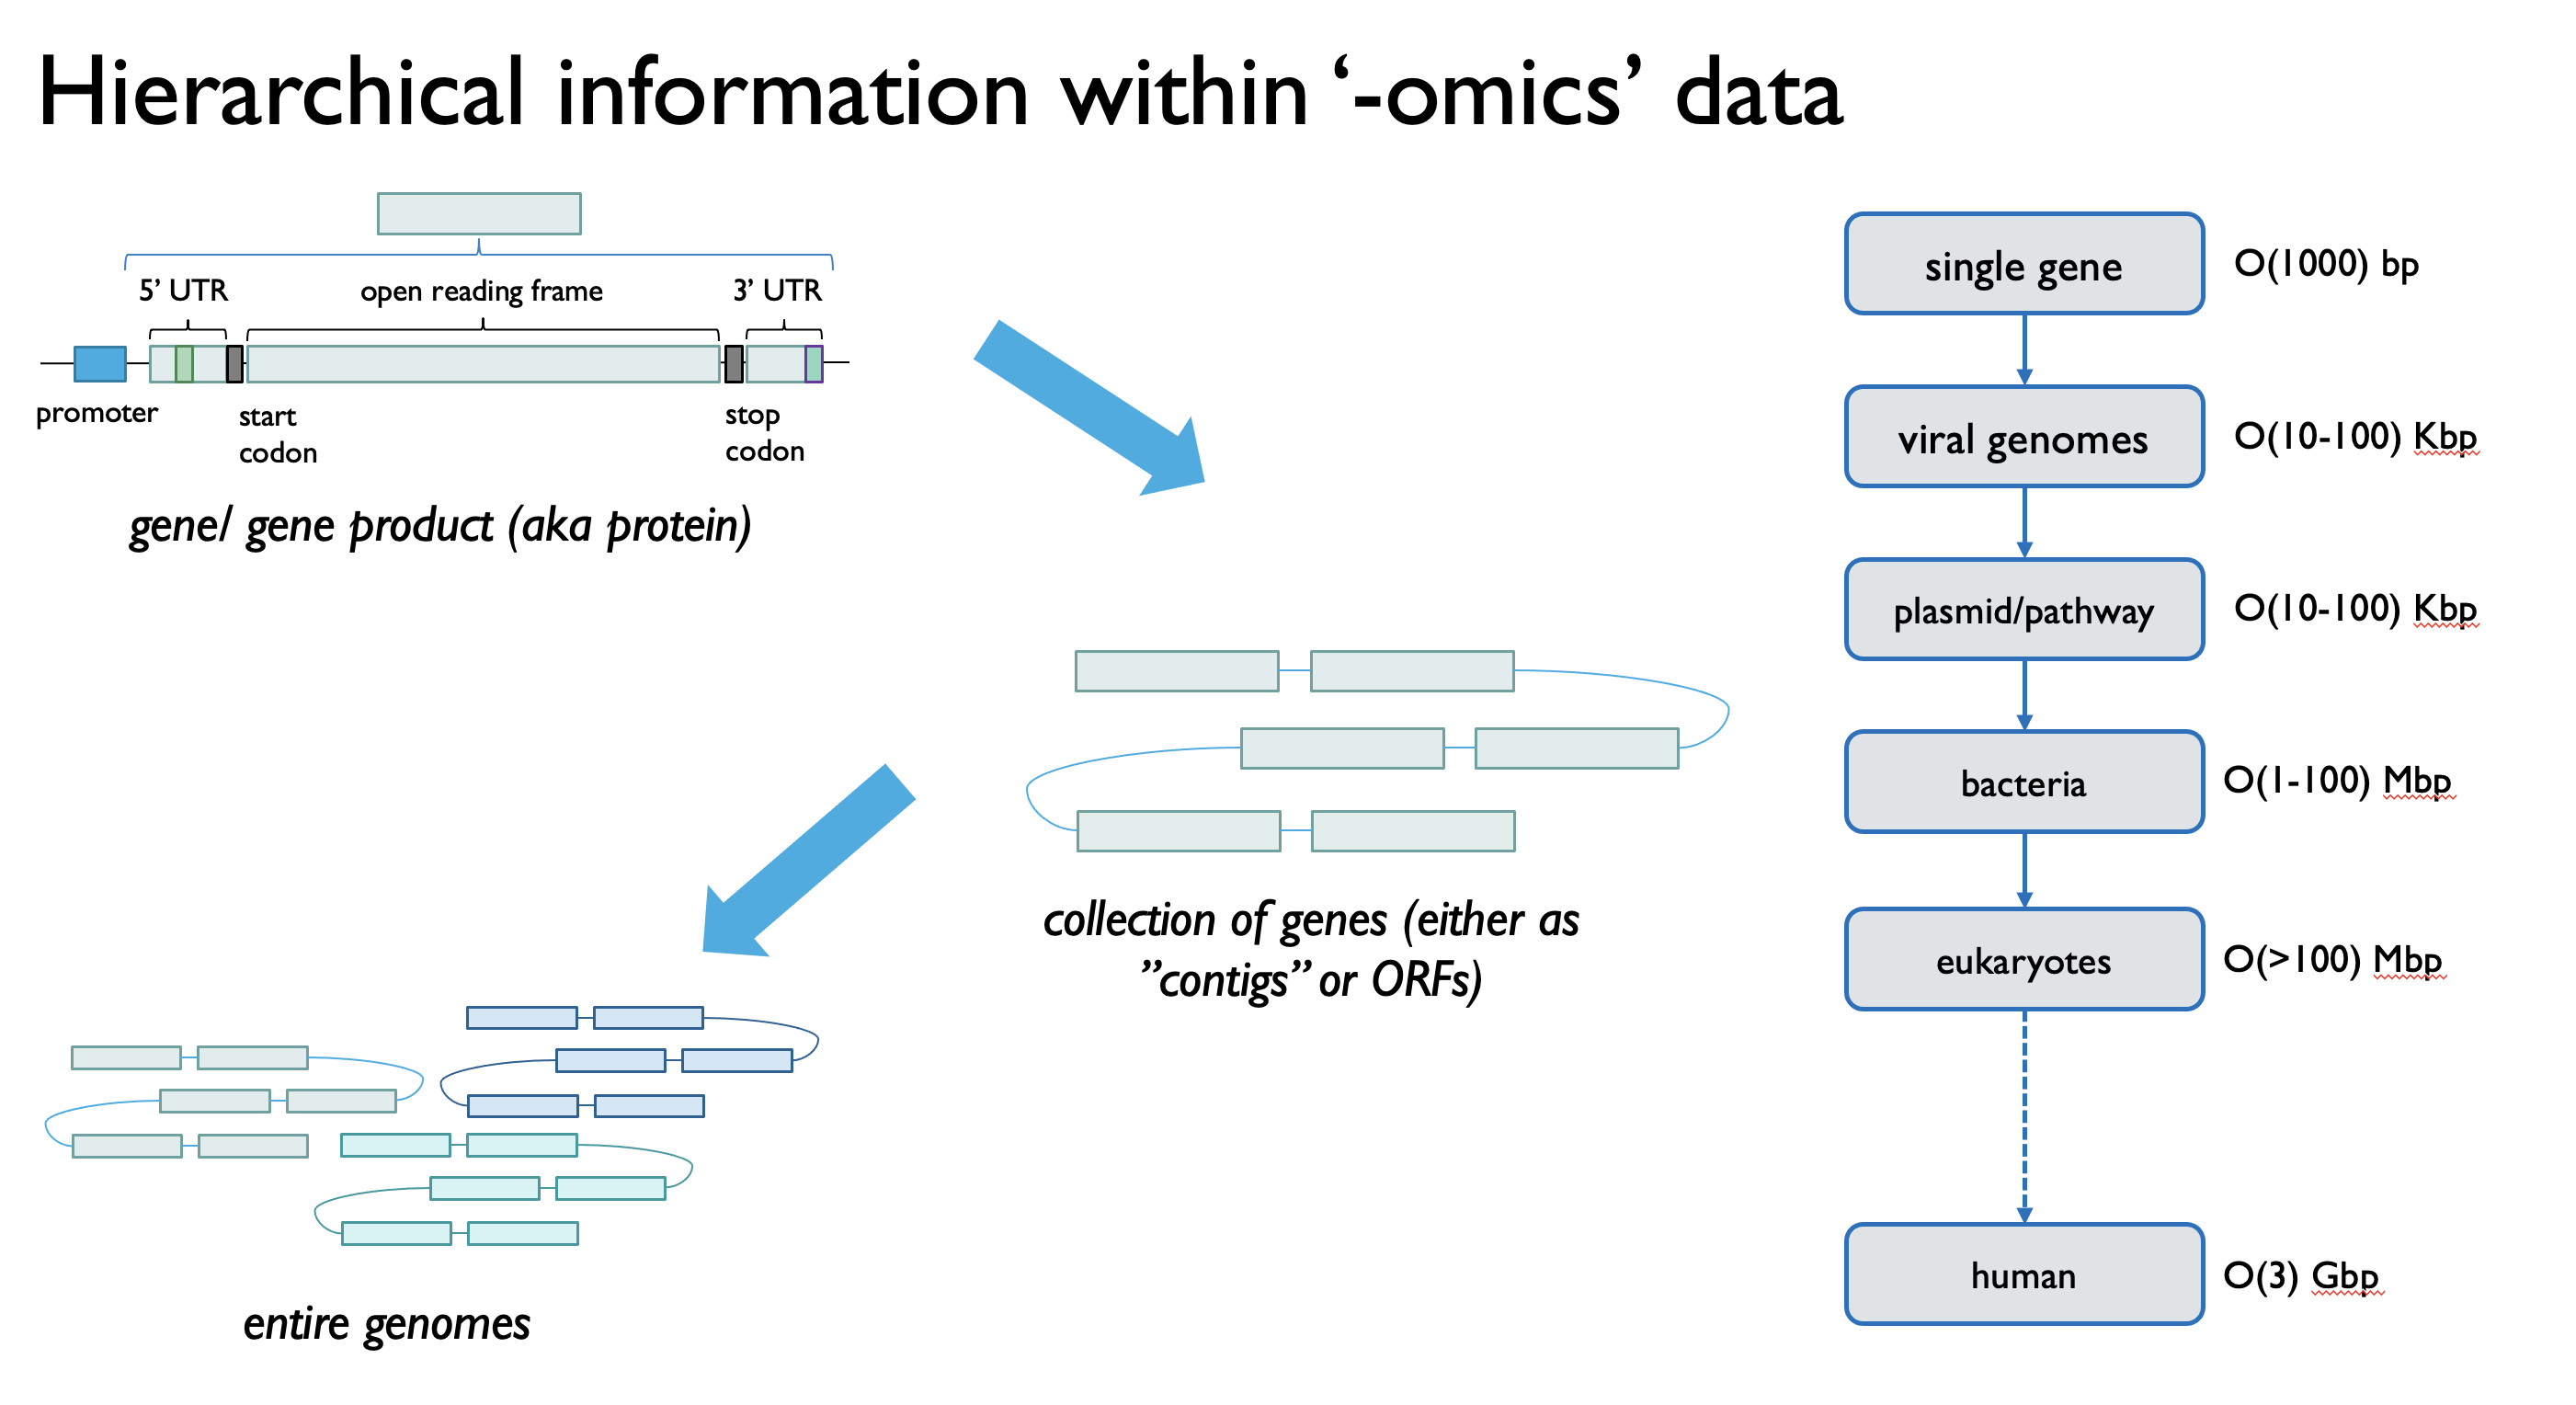